In [2]:
DATA_PATH='/home/sravya/data/muse/'
YOUTUBE_URL='https://www.youtube.com/watch?v=0jnojoBWOdo'
SYNTH_HOME = DATA_PATH+'SynthText/SynthText/'

In [3]:
import time
import datetime

# Youtube utilities

In [443]:
import random
import youtube_dl
TEST_VIDEOS = DATA_PATH + 'testvideos/'
def download_video(url,folder_path):
    """ Use youtube_dl to download the video from youtube in mp4 format and return the filepath.
    Like: youtube-dl -f 22 https://www.youtube.com/watch?v=0jnojoBWOdo --output='test.mp4'

    Arguments: 
    url -- Youtube video url to be downloaded
    folder_path -- Absolute path where the video needs to be downloaded. 
                A video file with naming video_[random number] would be created at that location.
                
    """
    video_path = folder_path + 'video_' + str(random.randint(1, 1000000))+'.mp4'
    ydl_opts = {'outtmpl': video_path, 'format': '22'}
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    print('Video downloaded to ' + video_path)
    return video_path

def test_download_video():
    start = time.time()
    video_path = downloadYouTubeVideo(YOUTUBE_URL, TEST_VIDEOS)
    end = time.time()
    assert os.path.exists(video_path) == 1
    print(video_path + ' exists')
    print('Youtube video download time: ' + str(datetime.timedelta(seconds=end - start)))
    
test_download_video()

[youtube] 0jnojoBWOdo: Downloading webpage
[youtube] 0jnojoBWOdo: Downloading video info webpage
[youtube] 0jnojoBWOdo: Extracting video information
[youtube] 0jnojoBWOdo: Downloading MPD manifest
[download] Destination: /home/sravya/data/muse/testvideos/video_462059.mp4
[download] 100% of 8.43MiB in 00:0038MiB/s ETA 00:008
/home/sravya/data/muse/testvideos/video_462059.mp4 exists
Youtube video download time: 0:00:01.969991


# ffmpy utilities

In [444]:
import ffmpy
def video_to_frames(video_path):
    """ Breakes video at the location video_path into frames and returns the directory path of pngs
    The directory would be video file name without extension. Fails if there exists such directory with content.
    Like: ffmpeg -i adobe.webm -vcodec png adobe/%04d.png
    """
    png_folder = video_path[:video_path.index('.')]
    if os.path.exists(png_folder):
        os.removedirs(png_folder)
    os.mkdir(png_folder)
    
    ff = ffmpy.FFmpeg(
    inputs={video_path: None},
    outputs={png_folder + '/%04d.png': '-vcodec png'})
    ff.run()
    
    return png_folder

import glob
def test_video_to_frames():
    video_path = downloadYouTubeVideo(YOUTUBE_URL, TEST_VIDEOS)

    start = time.time()
    png_folder = video_to_frames(video_path)
    end = time.time()
    assert os.path.exists(png_folder) == 1
    print(png_folder + ' exists')
    num_pngs = len(glob.glob(png_folder+'/*'))
    print(str(num_pngs) + ' frames created at ' + png_folder)
    assert num_pngs > 1   
    print('Time taken to break into frames: ' + str(datetime.timedelta(seconds=end - start)))

test_video_to_frames()

[youtube] 0jnojoBWOdo: Downloading webpage
[youtube] 0jnojoBWOdo: Downloading video info webpage
[youtube] 0jnojoBWOdo: Extracting video information
[youtube] 0jnojoBWOdo: Downloading MPD manifest
[download] Destination: /home/sravya/data/muse/testvideos/video_848269.mp4
[download] 100% of 8.43MiB in 00:0073MiB/s ETA 00:001
/home/sravya/data/muse/testvideos/video_848269 exists
10602 frames created at /home/sravya/data/muse/testvideos/video_848269
Time taken to break into frames: 0:01:09.800093


# pyOCR utilities

In [450]:
from PIL import Image
import sys
import pyocr
import pyocr.builders

def get_pyOCRtool():
    """ Check pyOCR installation and returns the recommended OCR tool"""
    tools = pyocr.get_available_tools()
    if len(tools) == 0:
        print("No OCR tool found")
        sys.exit(1) # TODO: Understand when to use system exit
    # The tools are returned in the recommended order of usage
    tool = tools[0]
    print("Will use tool '%s'" % (tool.get_name()))

    langs = tool.get_available_languages()
    print("Available languages: %s" % ", ".join(langs))
    return tool

def pyOCR_read(image_path, tool):
    """ Reads an image and returns word_boxes and text corresponding to it"""
    word_boxes = tool.image_to_string(
    Image.open(image_path),
    lang="eng",
    builder=pyocr.builders.WordBoxBuilder())
    return word_boxes

def visualizepyOCRBoxes(image_path):
    tool = get_pyOCRtool()
    word_boxes = pyOCR_read(image_path, tool)
    image = Image.open(image_path)
    im = np.array(image, dtype=np.uint8)
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    for box in word_boxes:
        rect = patches.Rectangle(box.position[0], 
                  box.position[1][0], 
                  box.position[1][1],
                 linewidth=1, edgecolor='r', facecolor='none', label=box.content)
        ax.add_patch(rect)
    plt.show()
    
def test_get_pyOCRtool():
    start = time.time()
    tool = get_pyOCRtool()
    end = time.time()
    assert tool is not None
    print('Time taken to get pyOCR tool ' + str(datetime.timedelta(seconds=end - start)))
    
def test_pyOCR_read():
    image_path = SYNTH_HOME + '1/' + random.choice(os.listdir(PATH))
    tool = get_pyOCRtool()
    start = time.time()
    word_boxes = pyOCR_read(image_path, tool)
    end = time.time()
    assert word_boxes is not None
    print("Test test_pyOCR_read passed")
    print('Time taken: ' + str(datetime.timedelta(seconds=end - start)))

In [451]:
test_get_pyOCRtool()

Will use tool 'Tesseract (sh)'
Available languages: eng, osd, equ
Time taken to get pyOCR tool 0:00:00.309453


In [452]:
test_pyOCR_read()

Will use tool 'Tesseract (sh)'
Available languages: eng, osd, equ
Test test_pyOCR_read passed
Time taken: 0:00:00.367295


Will use tool 'Tesseract (sh)'
Available languages: eng, osd, equ


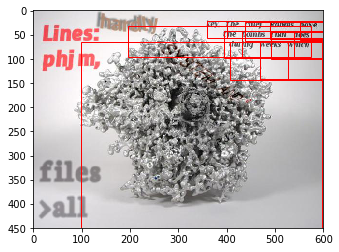

In [453]:
image_path = '/home/sravya/data/muse/SynthText/SynthText/1/ant+hill_116_54.jpg'
visualizepyOCRBoxes(image_path)

# SynthText utilities
Readme: http://www.robots.ox.ac.uk/~vgg/data/scenetext/readme.txt

In [1]:
import scipy.io
def load_synthtext_labels(path):
    """ Loads the SynthText labels and returns the matlab cell array"""
    return scipy.io.loadmat(path)

def get_index_from_filename(filename):
    """ Get index of mat file for a given file name"""
    for index,text in enumerate(mat['imnames'][0]):
        if text == filename:
            return index
    return -1

def transform_synth_text(mat):
    """ Text in SynthText are clubbed together with \n. 
    This utility function splits it out into a single dimensional text array for each image"""
    txt = []
    for i in range(mat['txt'][0].shape[-1]):# Each image
        new_text = []
        for j in range(mat['txt'][0][i].shape[-1]):#Number of text strings
            words = mat['txt'][0][i][j].split('\n')
            for k in words:
                new_text.append(k.strip())
        txt.append(new_text)
    return np.asarray(txt)
    
def visualize_synthtext(text_im, wordBB, text):
    """
    text_im : np image
    wordBB : 2x4xm matrix of word coordinates
    """
    plt.imshow(text_im)
    # plot the word-BB:
        
    for i in range(wordBB.shape[-1]): #Number of boxes
        bb = wordBB[:,:,i]
        bb = np.c_[bb,bb[:,0]]
        plt.plot(bb[0,:], bb[1,:], 'g', alpha=0.8)
        # visualize the indiv vertices:
        vcol = ['r','g','b','k']
        for j in range(4):
            plt.scatter(bb[0,j],bb[1,j],color=vcol[j])  
        plt.text(bb[0][0], bb[1][0], text[i].strip(), color='r')
    plt.show()

def find_clean_inputs(mat):
    """ Returns good indices where there is no missing text. """
    good_indices = []
    for index in range(mat['imnames'][0].shape[-1]):
        if(mat['wordBB'][0][index].shape[-1] == len(txt[index])):
            good_indices.append(index)
    return good_indices

def save_clean_inputs(folder_path):
    os.mkdir(folder_path+'processed')
    folder_path= folder_path+'processed/'
    good_indices = find_clean_inputs(mat)
    wordBB = mat['wordBB'][0][good_indices]
    text = transform_synth_text(mat)[good_indices]
    imnames = mat['imnames'][0][good_indices]
    numpysave(folder_path,imnames,wordBB,text)

def numpysave(folder_path,imnames,wordBB,text):
    np.save(folder_path+'imnames.npy', imnames)
    np.save(folder_path+'wordBB.npy', wordBB)
    np.save(folder_path+'text.npy', text)
    
def test_load_synthtext_labels():
    mat = load_synthtext_labels(SYNTH_HOME + 'gt.mat')
    assert mat is not None

def test_get_index_from_filename():
    filename = '1/' + random.choice(os.listdir(SYNTH_HOME + '1/'))
    assert get_index_from_filename(filename) is not -1

def test_visualize_synthtext(index):
    image = Image.open(SYNTH_HOME + str(mat['imnames'][0][index][0]))
#   filename = '1/' + random.choice(os.listdir(SYNTH_HOME + '1/'))
#    index = get_index_from_filename(filename)
    print(index)
    im = np.array(image, dtype=np.uint8)
    visualize_synthtext(im, wordBB=mat['wordBB'][0][index], text=mat['txt'][0][index])
    
def test_transform_synth_text():
    txt = transform_synth_text(mat)
    assert len(txt) == len(mat['txt'][0])
    
def test_save_clean_inputs(mat):
    save_clean_inputs(SYNTH_HOME)
    assert os.path.exists(SYNTH_HOME + 'processed/imnames.npy') == 1
    assert os.path.exists(SYNTH_HOME + 'processed/wordBB.npy') == 1
    assert os.path.exists(SYNTH_HOME + 'processed/text.npy') == 1
    assert np.load(SYNTH_HOME + 'processed/imnames.npy').size > 1
    assert np.load(SYNTH_HOME + 'processed/wordBB.npy').size > 1
    assert np.load(SYNTH_HOME + 'processed/text.npy').size > 1

In [582]:
test_transform_synth_text()

In [456]:
test_get_index_from_filename()

In [457]:
test_load_synthtext_labels()

In [586]:
txt = transform_synth_text(mat)

2


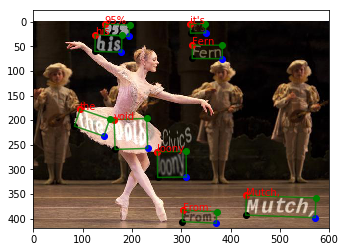

In [601]:
good_indices = find_clean_inputs(mat)
test_visualize_synthtext(good_indices[0])

In [655]:
test_save_clean_inputs(mat)

# SynthText Explore

In [4]:
mat = load_synthtext_labels(SYNTH_HOME + 'gt.mat')

In [7]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'charBB', 'wordBB', 'imnames', 'txt'])

In [8]:
# mat contains of multiple arrays of sample size
# imnames holds the filenames
# wordBB holds the word bounding boxes
# txt holds the text for each of the contigous boxes
mat['imnames'].shape, mat['wordBB'].shape, mat['txt'].shape

((1, 858750), (1, 858750), (1, 858750))

In [9]:
mat['imnames'][0][0].shape, mat['wordBB'][0][0].shape, mat['txt'][0][0].shape

((1,), (2, 4, 15), (8,))

In [10]:
#Bounding boxes and text corresponding to the file at index 0
mat['imnames'][0][0], mat['wordBB'][0][0], mat['txt'][0][0]

(array(['8/ballet_106_0.jpg'],
       dtype='<U18'),
 array([[[ 420.58956909,  418.85015869,  448.08477783,  410.30938721,
           117.74502563,  322.30963135,  322.68569946,  159.09138489,
           154.27284241,  260.14596558,  431.93148804,  427.5227356 ,
           296.86508179,   99.56819153,  108.96211243],
         [ 512.33209229,  431.88342285,  519.45147705,  499.81182861,
           179.05439758,  377.97381592,  376.4992981 ,  203.64463806,
           193.7749176 ,  313.61514282,  487.58023071,  484.64633179,
           365.83175659,  142.49403381,  144.90457153],
         [ 511.92202759,  428.70770264,  518.73748779,  499.03729248,
           172.168396  ,  378.35858154,  377.20779419,  203.31910706,
           193.07389832,  319.69186401,  485.67581177,  482.5710144 ,
           365.76303101,  142.31898499,  144.43858337],
         [ 420.17950439,  415.67443848,  447.37078857,  409.53485107,
           110.85902405,  322.69439697,  323.39419556,  158.76585388,
         

In [12]:
import numpy as np
BB = np.load(SYNTH_HOME + 'processed/wordBB.npy')

In [17]:
len(BB)

305600

In [14]:
wordBB = BB[0] #Per file

In [25]:
wordBB.shape[-1]

10

In [29]:
wordBB

array([[[ 322.58139038,  432.39447021,  163.69195557,  125.58459473,
          251.46273804,  318.38635254,  303.40826416,   94.90205383,
          144.70532227,  260.17541504],
        [ 383.39810181,  573.3258667 ,  229.71356201,  179.58337402,
          309.73019409,  349.14294434,  372.13763428,  154.65963745,
          195.24554443,  321.23156738],
        [ 383.20346069,  571.83081055,  231.84552002,  178.70343018,
          310.45059204,  349.64575195,  371.04364014,  142.95114136,
          194.15176392,  325.52618408],
        [ 322.38674927,  430.89941406,  165.82391357,  124.70465088,
          252.18313599,  318.88916016,  302.31427002,   83.19356537,
          143.61154175,  264.47003174]],

       [[  47.3973999 ,  352.71444702,  198.84484863,   26.69045258,
          264.1890564 ,    5.04874945,  382.74697876,  177.7064209 ,
            4.73935699,  215.09129333],
        [  47.83036804,  357.98629761,  196.52374268,   28.09816742,
          263.38247681,    4.20974922, 

In [33]:
b_index = 0
x_min_index = 0
x_max_index = 2
y_min_index = 0
y_max_index = 2
x_min,y_min = wordBB[0][x_min_index][b_index], wordBB[1][y_min_index][b_index]

In [34]:
x_min, y_min

(322.58139, 47.3974)

In [35]:
x_max, y_max = wordBB[0][x_max_index][b_index], wordBB[1][y_max_index][b_index]

In [36]:
x_max, y_max

(383.20346, 75.168411)

In [ ]:
x_min,y_min = wordBB[0][x_min_index][b_index], wordBB[1][y_min_index][b_index]

In [15]:
wordBB[0]

array([[ 322.58139038,  432.39447021,  163.69195557,  125.58459473,
         251.46273804,  318.38635254,  303.40826416,   94.90205383,
         144.70532227,  260.17541504],
       [ 383.39810181,  573.3258667 ,  229.71356201,  179.58337402,
         309.73019409,  349.14294434,  372.13763428,  154.65963745,
         195.24554443,  321.23156738],
       [ 383.20346069,  571.83081055,  231.84552002,  178.70343018,
         310.45059204,  349.64575195,  371.04364014,  142.95114136,
         194.15176392,  325.52618408],
       [ 322.38674927,  430.89941406,  165.82391357,  124.70465088,
         252.18313599,  318.88916016,  302.31427002,   83.19356537,
         143.61154175,  264.47003174]], dtype=float32)

In [38]:
text = np.load(SYNTH_HOME + 'processed/text.npy')

In [41]:
text[0][0]

'Fern'

In [602]:
#Pickle clean inputs
wordBB = mat['wordBB'][0][good_indices]
text = txt[good_indices]

len(mat['wordBB'][0]), len(txt), len(wordBB), len(text)

(858750, 858750, 305600, 305600)

In [ ]:
#Store using bcolz TODO: storing variable length matrices is not working
fname = SYNTH_HOME + 'processed/text.dat'
c=bcolz.carray(text, rootdir=fname, mode='w')
c.flush()
new_text = bcolz.open(fname)[:]

fname = SYNTH_HOME + 'processed/imnames.dat'
c=bcolz.carray(mat['imnames'][0][good_indices], rootdir=fname, mode='w')
c.flush()
new_imnames = bcolz.open(fname)[:]

fname = SYNTH_HOME + 'processed/wordBB.dat'
c=bcolz.carray(wordBB, rootdir=fname, mode='w')
c.flush()
new_wordBB = bcolz.open(fname)[:]

In [642]:
#Tried it differently
import bcolz
fname = SYNTH_HOME + 'processed/wordBB.dat'
c = bcolz.carray(rootdir=fname, mode='w')
for i in range(wordBB.size):
    c.append(wordBB[i])
c.flush()
new_wordBB = bcolz.open(fname)[:]

ValueError: array trailing dimensions do not match with self

In [662]:
mat['imnames'][0][good_indices[0]][0]

'8/ballet_106_10.jpg'

In [668]:
filename = mat['imnames'][0][good_indices[1]][0]
img = Image.open(SYNTH_HOME + filename)

In [670]:
img.size == (600,419)

True

In [673]:
size = (600,419)
sizes = [size]
for filename in glob.glob(SYNTH_HOME + '*/*.png'):
    img = Image.open(filename)
    if(img.size != size):
        sizes = sizes + img.size   

In [674]:
sizes

[(600, 419)]

# Resize for VGG

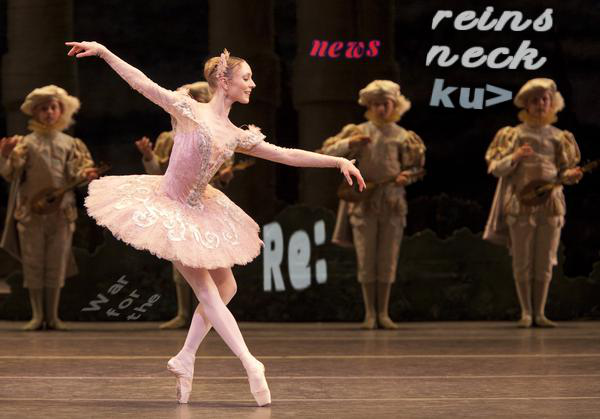

In [675]:
img

In [693]:
filename='/home/sravya/data/muse/SynthText/SynthText/8/abc.png'
heirarchy = filename.split('/')
heirarchy[-3] = 'SynthText-resized'
'/'.join(heirarchy)

'/home/sravya/data/muse/SynthText/SynthText-resized/8/abc.png'

'/home/sravya/data/muse/SynthText/SynthText-resized/'

In [699]:
SYNTH_HOME


'/home/sravya/data/muse/SynthText/SynthText/'

In [700]:
glob.glob(SYNTH_HOME + '*/*.jpg')

['/home/sravya/data/muse/SynthText/SynthText/154/sandwich_6_71.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_6_53.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_6_96.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_72_50.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_66_63.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_78_79.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_46_77.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_4_93.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_69_71.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_51_16.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_67_76.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_44_70.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_74_86.jpg',
 '/home/sravya/data/muse/SynthText/SynthText/154/sandwich_47_39.jpg',
 '/home/sravya/data/muse

In [697]:
for filename in glob.glob(SYNTH_HOME + '*/*.png'):
    print(filename)
    break

In [701]:
IMAGENET_SIZE = (224,224)
for filename in glob.glob(SYNTH_HOME + '*/*.jpg'):
#for filename in ['/home/sravya/data/muse/SynthText/SynthText/1/ant+hill_116_54.jpg']:
    img = Image.open(filename)
    img.resize(IMAGENET_SIZE)
    heirarchy = filename.split('/')
    heirarchy[-3] = 'SynthText-resized'
    if not os.path.exists('/'.join(heirarchy[:-1])):
        os.makedirs('/'.join(heirarchy[:-1]))                          
        #print("Creating directory " + '/'.join(heirarchy[:-1]))
    img.save('/'.join(heirarchy))
    #print("Saved file at " + '/'.join(heirarchy))

OSError: image file is truncated (58 bytes not processed)

# TODO
1. Implement visualize_frames(images[],boxes[],text[]) - boxes and text can be empty for frames with no text
2. Implement get_text_bb(image) - returns boxes[], text[] (model.infer)
3. Implement get_text_bb(video) - returns frames, boxes[], text[]